In [1]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow
from tensorflow import keras
print(tensorflow.__version__)
print(keras.__version__)

2.19.0
3.10.0


In [3]:
import os
os.chdir('/content/drive/MyDrive/ECG-Classification')

In [4]:
!pip install PyWavelets
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 91.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


In [4]:
import wfdb
import pywt
import seaborn
import numpy as np
import matplotlib.pyplot as plt

In [5]:
number = "100"
record = wfdb.rdrecord('./data/mit-bih-arrhythmia-database-1.0.0/' + number, channel_names=['MLII'])
data = record.p_signal.flatten()

# 获取心电数据记录中R波的位置和对应的标签
annotation = wfdb.rdann('./data/mit-bih-arrhythmia-database-1.0.0/' + number, 'atr')
Rlocation = annotation.sample
Rclass = annotation.symbol

In [6]:
from collections import Counter
print(len(data))
print(len(Rlocation))
print(Counter(Rclass))
print(Rlocation[:10])

650000
2274
Counter({'N': 2239, 'A': 33, '+': 1, 'V': 1})
[  18   77  370  662  946 1231 1515 1809 2044 2402]


/usr/local/lib/python3.11/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(


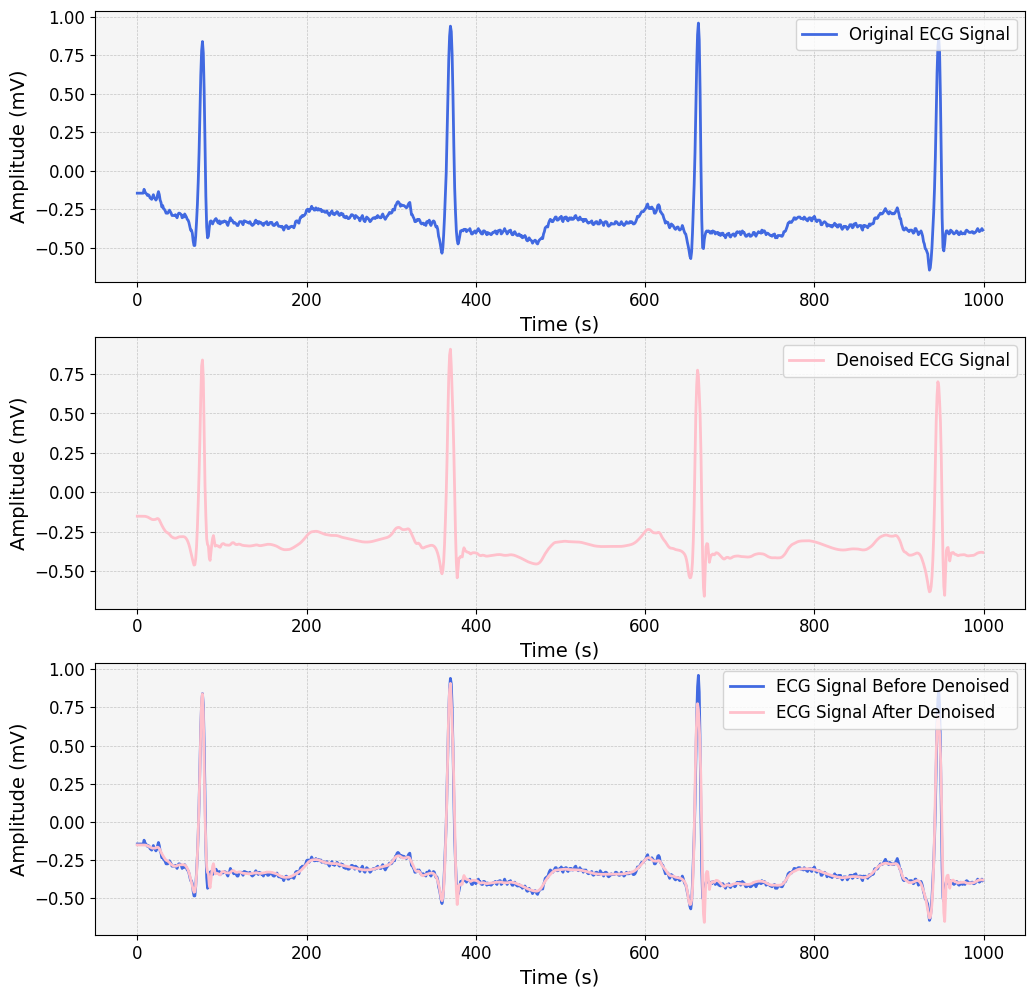

In [27]:
# 小波去噪预处理
def denoise(data):
    # 小波变换
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # 阈值去噪
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # 小波反变换,获取去噪后的信号
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

signal = data[:1000]
plt.figure(figsize=(12, 12))

def plot_ecg_signal(ax, data, title, color='blue',label=None):
    ax.plot(data, color=color, linewidth=2, label=label)  # 设置线条宽度

    ax.set_xlabel("Time (s)", fontsize=14)
    ax.set_ylabel("Amplitude (mV)", fontsize=14)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # 添加网格
    ax.tick_params(axis='both', labelsize=12)
    ax.set_facecolor('whitesmoke')  # 设置背景颜色

ax1 = plt.subplot(3, 1, 1)
plot_ecg_signal(ax1, signal, "", color='royalblue',label='Original ECG Signal')
plt.legend(loc='upper right', fontsize=12)

ax1 = plt.subplot(3, 1, 2)
plot_ecg_signal(ax1, denoise(signal), "", color='pink',label='Denoised ECG Signal')
plt.legend(loc='upper right', fontsize=12)

ax1 = plt.subplot(3, 1, 3)
plot_ecg_signal(ax1, signal, "", color='royalblue',label='ECG Signal Before Denoised')
plot_ecg_signal(ax1, denoise(signal), "", color='pink',label='ECG Signal After Denoised')
plt.legend(loc='upper right', fontsize=12)


plt.savefig('./Denoised2.jpeg', format='jpeg',dpi=600, bbox_inches='tight')
plt.show()
# from matplotlib.gridspec import GridSpec

# plt.figure(figsize=(12, 9))
# gs = GridSpec(2, 2)  # 定义2行3列的网格布局

# # 第一幅子图 (占用第1行第1列)
# ax1 = plt.subplot(gs[0, 0])
# plot_ecg_signal(ax1, signal, "", color='royalblue', label='Raw ECG Signal')
# ax1.legend(loc='upper right')

# # 第二幅子图 (占用第1行第2列)
# ax2 = plt.subplot(gs[0, 1])
# plot_ecg_signal(ax2, denoise(signal), "", color='pink', label='Denoised ECG Signal')
# ax2.legend(loc='upper right')

# # 第三幅子图 (占用第2行整行)
# ax3 = plt.subplot(gs[1, :])
# plot_ecg_signal(ax3, signal, "Comparison of Signals", color='royalblue', label='Before Denoised')
# plot_ecg_signal(ax3, denoise(signal), "", color='pink', label='After Denoised')
# ax3.legend(loc='upper right')

# # 保存图像并展示
# plt.savefig('./Comparation of ECG Signal before and after Denoised.jpeg', format='jpeg', dpi=300, bbox_inches='tight')
# plt.show()


['+', 'N', 'N', 'N', 'N']


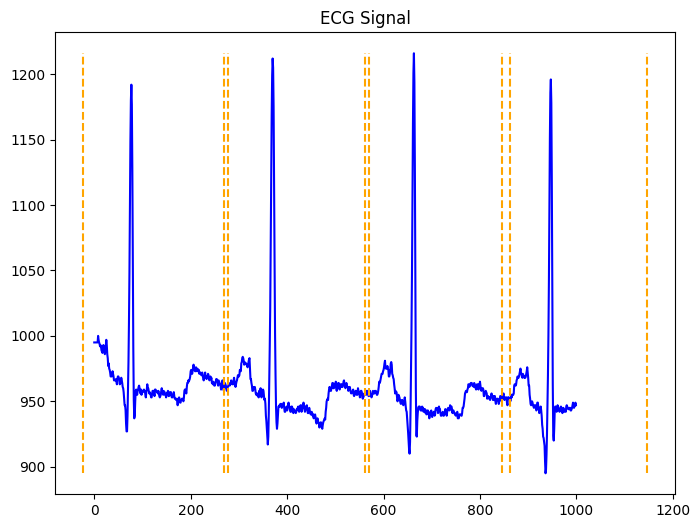

In [ ]:
import wfdb
import matplotlib.pyplot as plt

record = wfdb.rdrecord('./data/mit-bih-arrhythmia-database-1.0.0/100',
                       sampfrom=0,
                       sampto=1000,
                       physical=False,
                       channel_names=['MLII'])

# 转为数字信号
signal = record.d_signal[0:1000]

# 绘制波形
plt.figure(figsize=(8, 6))
plt.plot(signal, color="blue")
plt.title("ECG Signal")


# 读取annatations
signal_ann = wfdb.rdann("./data/mit-bih-arrhythmia-database-1.0.0/100", "atr", sampfrom=0, sampto=1000)

# 将读取到的annatations的心拍绘制到心电图上
for index in signal_ann.sample:
    if index > 18:
      plt.vlines(index-100, min(signal), max(signal), color='orange', linestyle='dashed')
      plt.vlines(index+200, min(signal), max(signal), color='orange', linestyle='dashed')

# 并打印出改心拍标注的类型
print(signal_ann.symbol)
plt.show()

In [ ]:
signal_ann.sample

array([ 18,  77, 370, 662])

In [ ]:
Rlocation

array([    18,     77,    370, ..., 649484, 649734, 649991])

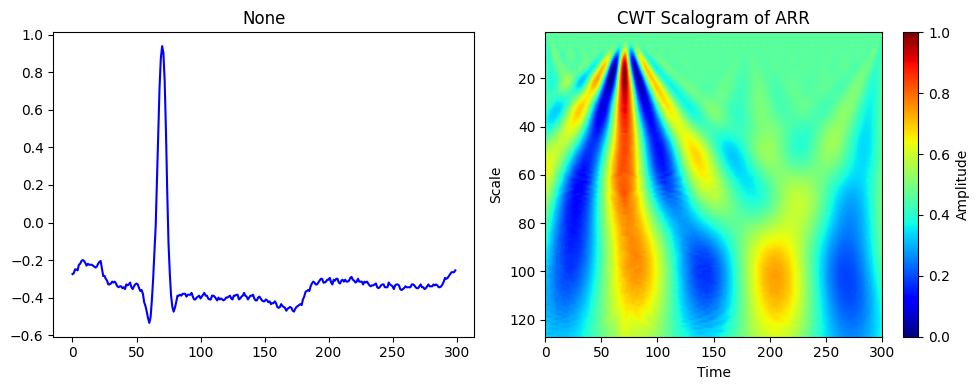

In [ ]:
def plot_cwt_image(signal, scales, wavelet='morl', img_size=(128, 128), title_name=None):
    """
    # 尺度图
    """
    # Compute CWT
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet)

    # Normalize coefficients for better visualization
    normalized_coefficients = (coefficients - coefficients.min()) / (coefficients.max() - coefficients.min())

    # Plot original coefficients
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(signal,color='blue')
    plt.title("%s" % title_name)

    plt.subplot(1, 2, 2)
    plt.imshow(normalized_coefficients, aspect='auto', cmap='jet', extent=[0, len(signal), scales[-1], scales[0]])
    plt.colorbar(label='Amplitude')
    plt.title("CWT Scalogram of ARR")
    plt.xlabel("Time")
    plt.ylabel("Scale")


    plt.tight_layout()
    plt.show()


# Define CWT parameters
scales = np.arange(1, 128)  # Example: 100 scales
img_size = (128, 128)       # Image size for CNN
signal = data[300:600]
plot_cwt_image(signal, scales, wavelet='morl', img_size=img_size)

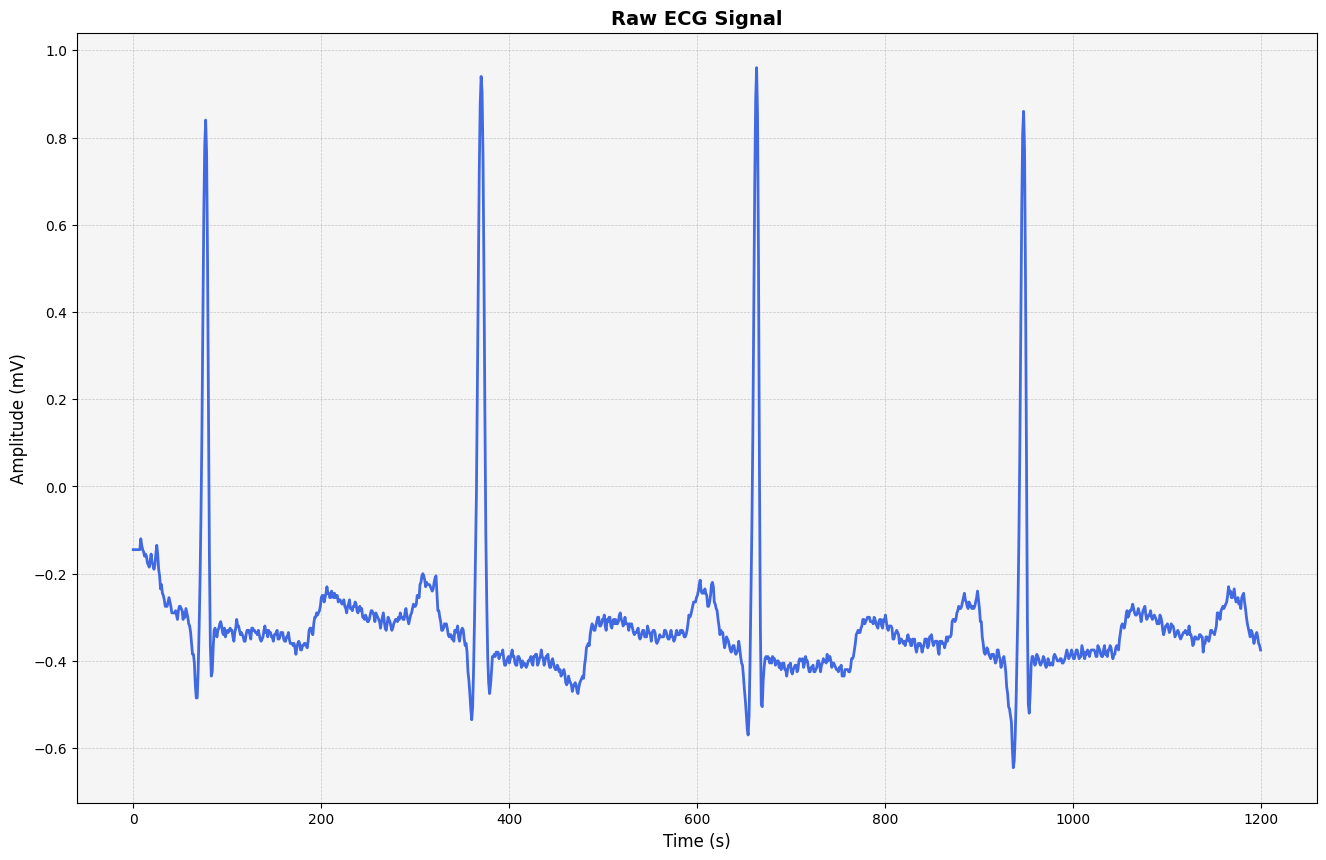

In [ ]:
# 绘制波形

plt.figure(figsize=(16, 10))
# 通过定义一个函数来重复绘制过程，减少冗余代码
def plot_ecg_signal(ax, data, title, color='blue'):
    ax.plot(data, color=color, linewidth=2)  # 设置线条宽度
    ax.set_xlabel("Time (s)", fontsize=12)
    ax.set_ylabel("Amplitude (mV)", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # 添加网格
    ax.tick_params(axis='both', labelsize=10)
    ax.set_facecolor('whitesmoke')  # 设置背景颜色

ax1 = plt.subplot(1, 1, 1)
plot_ecg_signal(ax1, data[:1200], "Raw ECG Signal", color='royalblue')
plt.savefig('./ECG_Signal.jpeg', format='jpeg',dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# 小波去噪预处理
def denoise(data):
    # 小波变换
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # 阈值去噪
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # 小波反变换,获取去噪后的信号
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

rdata = denoise(data=signal)

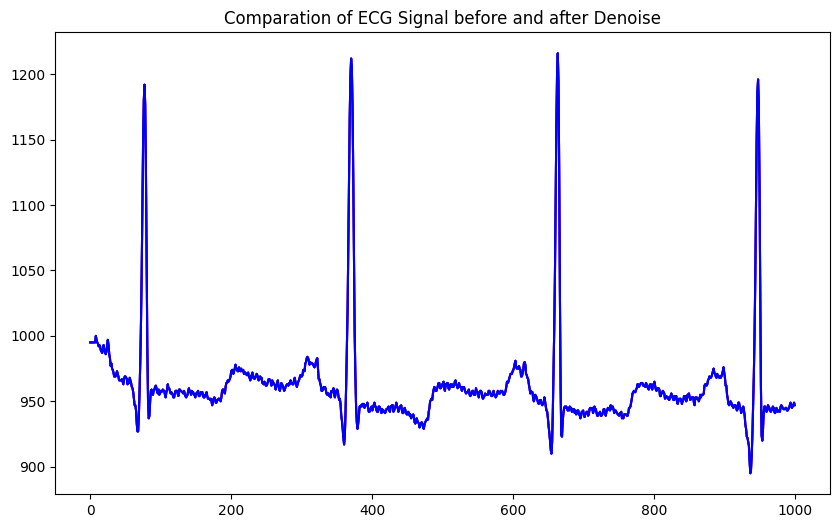

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(signal,color="red", label='Raw ECG Signal')
plt.plot(rdata, color="blue", label='Denoise ECG Signal')
plt.legend(loc='upper right')
plt.title("Comparation of ECG Signal before and after Denoise")
plt.show()